### Ellipse detection with Fizyr Retinanet

Note this notebook is based on : https://www.freecodecamp.org/news/object-detection-in-colab-with-fizyr-retinanet-efed36ac4af3/ and the associated github : https://github.com/RomRoc/objdet_fizyr_colab 

If a title is double underlined it means that the code is taken from these tutorials.






# Setup Git

In [1]:
! pip install keras==2.3.0

#Get RetinaNet git
!git clone https://github.com/fizyr/keras-retinanet.git

     |████████████████████████████████| 378kB 4.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
Cloning into 'keras-retinanet'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5410 (delta 8), reused 7 (delta 2), pack-reused 5388
Receiving objects: 100% (5410/5410), 14.71 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (3604/3604), done.



## Initialize The Dataset


In [2]:
#In your google drive you shall have a zip file containing all the images
#If you don't want to download the dataset on your drive 
#  Use https://drive.google.com/open?id=1YaTLY35XJEoc0UdfntU1XZ0BkZsLI9t2 and add the dataset to your drive as shared object
#  Same goes for the pretrained weights made: https://drive.google.com/file/d/1viBlzp2f5c0S100zc4CAYDh8KbjRNZgS/view?usp=sharing 

Download and add to your drive

from google.colab import drive
drive.mount('/content/drive')


! unzip /content/drive/My\ Drive/CV2019_Project.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/CV2019_Project.zip
  inflating: CV2019_Annots.csv       
  inflating: CV2019_Annots.txt       
  inflating: CV2019_Images.txt       
   creating: Example/
  inflating: Example/elps_eye01_2014-11-27_02-38-00-007.png  
  inflating: Example/elps_eye01_2014-11-27_02-38-15-000.png  
  inflating: Example/elps_eye01_2014-11-27_02-38-30-001.png  
  inflating: Example/elps_eye01_2014-11-27_02-38-45-002.png  
  inflating: Example/elps_e

In [3]:
#We remove all the images which are not of our interest 
#We only keep the soccer ellipses

! rm /content/Example/elps_eye*.png
! rm /content/Example/line*.png
! rm /content/Example/soccer*.png

! rm /content/Team0*/elps_eye*.png
! rm /content/Team0*/line*.png
! rm /content/Team0*/soccer*.png

rm: cannot remove '/content/Example/soccer*.png': No such file or directory


In [0]:
#Create train directory
! mkdir /content/train
! cp -r /content/Example/* /content/train
! cp -r /content/Team0*/* /content/train

In [0]:
# Create From Annotation CSV file create XML file with the annotations for each image

import csv
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET

with open('/content/drive/My Drive/CV2019_Annots_ElpsSoccer.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0

    old_row = None
    for row in csv_reader:
      
      if old_row != row[0] :
        if old_row !=None:
          f.write("</annotation>\n")
          f.close()
        x = row[0]
        x = x[:-4]
        name = f"/content/train/{x}.xml"
        f = open(name, "w")
        f.write("<annotation>\n")
        f.write("\t<folder>ellipse</folder>\n")
        f.write("\t<filename>"+row[0]+"</filename>\n")
        f.write("\t<path>train/"+row[0]+"</path>\n")
        f.write("\t<source>\n\t\t<database>Unknown</database>\n\t</source>\n")
        im = Image.open('/content/train/'+row[0])
        width, height = im.size
        f.write("\t<size>\n")	
        text = f"\t\t<width>{width}</width>\n\t\t<height>{height}</height>\n\t\t<depth>3</depth>\n\t</size>\n\t<segmented>0</segmented>\n"
        f.write(text)
        old_row = row[0]
      
      f.write('\t<object>\n\t\t<name>ellipse</name>\n\t\t<pose>Unspecified</pose>\n\t\t<truncated>0</truncated>\n\t\t<difficult>0</difficult>\n\t\t<bndbox>\n')
      Ymin = 100000
      Ymax = 0
      Xmin = 100000
      Xmax = 0 
      for  i in range(0,np.size(row)-3,2):
        x = i+3
        if x+1<np.size(row) and row[x+1]:
          #print('x+1'+row[x+1])
          Ymin = min(Ymin,int(round(float(row[x+1]))))
          Ymax = max(Ymax,int(round(float(row[x+1]))))
          
        if row[x]!=' ':
          #print('x'+row[x]+' a')
          Xmin = min(Xmin,int(round(float(row[x]))))
          Xmax = max(Xmax,int(round(float(row[x]))))

      if Xmin<0:
          Xmin = 0
      if Ymax > height:
          Ymax = height
      if Ymin <0:
          Ymin = 0

      if Xmax > width:
          Xmax = width

      if Xmin > Xmax : 
        Xmin = Xmax-1

      text =f'\t\t\t<xmin>{Xmin}</xmin>\n'
      f.write(text)
      text =f'\t\t\t<ymin>{Ymin}</ymin>\n'
      f.write(text)
      text =f'\t\t\t<xmax>{Xmax}</xmax>\n'
      f.write(text)
      text =f'\t\t\t<ymax>{Ymax}</ymax>\n'
      f.write(text)
      f.write("\t\t</bndbox>\n\t</object>\n")

    f.write("</annotation>\n")
    f.close()

## Initializing Retinanet



In [6]:
%cd keras-retinanet

#Due to an actual mistake in their current GitHub (date : 14/12/19)
#We had to find a working previous version
! git log
! git reset --hard 71b3d7524a1b6e166bd0295a47a90a4b3f06c58e

/content/keras-retinanet
commit a70c929db41eb7f31ddf972a49002dce5f93360b (HEAD -> master, origin/master, origin/HEAD)
Merge: 56c6998 050cdca
Author: Maarten de Vries <maarten@de-vri.es>
Date:   Fri Dec 13 10:01:03 2019 +0100

    Merge pull request #1220 from SalahAdDin/patch-1
    
    Update train.py

commit 050cdcac232e7bd1bc1fa952592dc9e25995a535
Author: José Luis <alagunasalahaddin@live.com>
Date:   Fri Dec 13 11:31:16 2019 +0300

    Update train.py
    
    Added missing `,`.

commit 56c699893e3212b2804f68fddacf11f4cfc654e9
Merge: 216e6de 89d3f52
Author: Hans Gaiser <h.gaiser@fizyr.com>
Date:   Thu Dec 12 09:35:46 2019 +0100

    Merge pull request #1169 from SalahAdDin/eval
    
    Implemented F1 score for assessments.

commit 89d3f52c3b292873bab27e0b0f01056c9e20ff14
Author: José L. S. A <alagunasalahaddin@live.com>
Date:   Wed Dec 11 16:16:17 2019 +0300

    Adding F1 Scores to callback evaluation.

commit c6ad6db7171aa27493b3842e3c0c029b90dddd71
Author: José L. S. A <alaguna

In [7]:
!pip install .

Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169828 sha256=c26cde99e90d9cf4f2254e5226604ad3aab6203262ecc0d2bbe0817a0095c423
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13344 sha256=c3404a9acef61cf892adb5f858aeff09a975f6808b1eefc7137eea6d1531b979
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [8]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

## Initializing annotation , directory and Classes!


---



---





In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [0]:
DATASET_DIR = '/content/train/'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
#Creates annotations.csv file containing all the annotations
#Creates classes.csv containing all the names of the classes detected

annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Training Model

---



---


In [15]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
#URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
#urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
DRIVE_MODEL = '/content/drive/My Drive/resnet50_csv_100.h5'
shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [19]:
#For real training:
#!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 20 --steps 50 --epochs 100 csv annotations.csv classes.csv
#Just to retrieve the associated tensor flow objects$
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 1 --steps 1 --epochs 1 csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

2019-12-14 18:58:06.995225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-14 18:58:07.017715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-12-14 18:58:07.018276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2019-12-14 18:58:07.018545: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2019-12-14 18:58:07.020386: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library 

# Inference


---



---


Run inference with uploaded image on trained model.

In [0]:
THRES_SCORE = 0.39 #Tuned by MIFTARI Bardhyl

In [21]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [33]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

#model_path = '/content/drive/My Drive/resnet50_csv_100.h5'

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_01.h5
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors


In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving line_soccer_00074.png to line_soccer_00074.png
Running inference on: line_soccer_00074.png
processing time:  1.9820284843444824


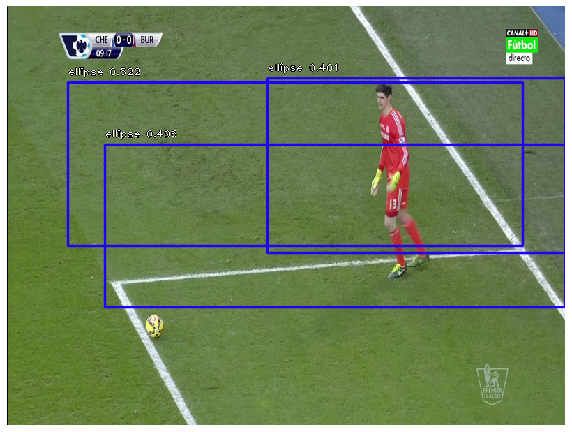

In [35]:
#Run and upload your image

uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

#images are saved in /content/keras-retinanet